In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import teotil3 as teo

plt.style.use("ggplot")

# Task 2.4: Calculate residence times

## Part B: Estimate mean flows

From the proposal text:

> **Oppgave 2.4: Beregne oppholdstider**
>
> NVEs innsjødybdedatabase skal brukes til å utvikle en statistisk modell som kan forutsi innsjøvolum (og dermed oppholdstid). Standardtilnærmingen vil bruke en regresjon av gjennomsnittlig vanndybde mot innsjøarealet (som i den opprinnelige TEOTIL modellen). Ytterligere kovariater, slik som gjennomsnittlig helning og høyde, vil også bli utforsket for å lage en mer robust statistisk modell, hvis mulig. Tilpasset regresjon vil bli brukt til å estimere innsjøvolum og oppholdstid for innsjøer langs hovedelver i hvert reginefelt. En Jupyter-notisbok som dokumenterer den statistiske utforskningen vil bli lagt til TEOTILs dokumentasjon.

## 1. Combine estimated and measured lake volumes

The notebook for Part A derived a statistical model for estimating lake volumes and applied this to >50k lakes with a surface area of more than 0.025 km2 (as in the original TEOTIL). I will use the measured volumes where available (< 400 lakes) and the the predicted volumes for everything else.

In [3]:
# Read estimated volumes from statistical analysis
dtm_res = 10
stats_csv = f"../../data/lake_volume_estimates_{dtm_res}m_dem.csv"
lake_df = pd.read_csv(stats_csv)
print(len(lake_df), "lakes in the dataset.")
print(
    "Measured volumes will be used for", (~pd.isna(lake_df["vol_Mm3"])).sum(), "lakes."
)

# Use measured volumes where available and estimated volumes otherwise
lake_df["vol_Mm3"] = lake_df["vol_Mm3"].combine_first(lake_df["vol_est_Mm3"])
assert pd.isna(lake_df["vol_Mm3"]).sum() == 0

# Some residence times reported by NVE are zero, which doesn't make sense
# Set to NaN
lake_df["res_time_yr"] = np.where(
    lake_df["res_time_yr"] == 0, np.nan, lake_df["res_time_yr"]
)

lake_df.head()

53527 lakes in the dataset.
Measured volumes will be used for 389 lakes.


,vatnLnr,name,regine,vassom,elev_m,area_km2,catch_area_km2,vol_est_avail,vol_Mm3,res_time_yr,width_km,aspect_ratio,slp_mean,vol_est_Mm3
0,505,Aahkanjaevrie,155.D1B,155,718.0,3.4267,16.06,0,127.800144,NaN,0.640903,8.342478,19.750757,127.800144
1,42531,Sijliesjaevrie,155.D32,155,585.0,0.4929,6.87,0,3.262779,NaN,0.192160,13.349850,7.005558,3.262779
2,45240,Gullriktjørnene,155.4C,155,749.0,0.0565,1.56,0,0.281389,NaN,0.063771,13.904983,13.797532,0.281389
3,91116,Ryptjønna,155.AA0,155,774.0,0.0288,0.30,0,0.077507,NaN,0.100792,2.830671,6.651130,0.077507
4,42243,Grubblivatnet,155.D8,155,495.0,0.0813,1.18,0,0.517594,NaN,0.201466,2.002869,10.540377,0.517594


## 2. Estimate mean flows

Unfortunately, the lakes database does not contain any information relating to mean flow, so this will need to be estimated from other datasets. The tidied regine dataset developed as [part of Task 2.1](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-1b_update_core_datasets.ipynb) provides a starting point.

In [4]:
# Read tidied regine data
reg_year = 2022
admin_year = 2022
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{reg_year}"
teo_gpkg = os.path.join(data_fold, "tidied", f"teotil3_data.gpkg")
reg_gdf = gpd.read_file(
    teo_gpkg, layer=f"regine_{reg_year}_admin_{admin_year}", driver="GPKG"
)

# Get just relevant columns
cols = [
    "regine",
    "a_cat_land_km2",
    "a_cat_poly_km2",
    "upstr_a_km2",
    "upstr_runoff_Mm3/yr",
    "q_sp_m3/s/km2",
    "runoff_mm/yr",
    "q_cat_m3/s",
    "a_lake_km2",
    "a_lake_nve_km2",
    "vassom",
    "fylnr",
    "komnr",
    "ospar_region",
    "geometry",
]
reg_gdf = reg_gdf[cols]
reg_gdf.head()

,regine,a_cat_land_km2,a_cat_poly_km2,upstr_a_km2,upstr_runoff_Mm3/yr,q_sp_m3/s/km2,runoff_mm/yr,q_cat_m3/s,a_lake_km2,a_lake_nve_km2,vassom,fylnr,komnr,ospar_region,geometry
0,001.10,1.16,1.442790,0.00,0.00,0.01393,439.597368,0.016159,0.000013,0.000000,001,30,3001,Skagerrak,"MULTIPOLYGON (((297006.830 6543966.950, 297169..."
1,001.1A1,1.43,1.432479,777.90,448.15,0.01419,447.802344,0.020292,0.048098,0.043955,001,30,3001,Skagerrak,"MULTIPOLYGON (((297505.440 6543157.790, 297543..."
2,001.1A20,0.34,0.340160,777.90,448.15,0.01036,326.936736,0.003522,0.036623,0.000000,001,30,3001,Skagerrak,"MULTIPOLYGON (((297770.368 6543429.036, 297787..."
3,001.1A2A,17.65,17.647822,58.96,22.97,0.01210,381.846960,0.213565,0.122567,0.186340,001,30,3001,Skagerrak,"MULTIPOLYGON (((299678.370 6544460.320, 299667..."
4,001.1A2B,41.30,41.298255,41.30,16.23,0.01245,392.892120,0.514185,7.513687,7.344123,001,30,3001,Skagerrak,"MULTIPOLYGON (((303353.460 6552989.330, 303341..."


This dataset contains long-term (1961-90) average runoff for each regine based on work by NVE. I can use the new TEOTIL model to build a catchment network from this dataset, and then accumulate flows from each regine downstream, just like the old TEOTIL model accumulated fluxes of total N and P. This will provide estimates of long-term mean discharge for the outflows of each regine, which can then be linked to the dataset of lake volumes.

The code below uses the `assign_regine_hierarchy` function in the new TEOTIL model to build a catchment network from the regine dataset.

In [5]:
# Determine hydrological connectivity using TEOTIL
reg_gdf = teo.io.assign_regine_hierarchy(
    reg_gdf,
    regine_col="regine",
    regine_down_col="regine_down",
    nan_to_vass=True,
    add_offshore=True,
    order_coastal=False,
    land_to_vass=True,
)

100.00 % of regines assigned.


`q_cat_m3/s` is a required input parameter in TEOTIL, and it is accumulated just like any other flux (see [Tutorial 1](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/tutorials/01_basic_concepts.ipynb) for an overview). The code below runs the model without any other input data and then joins the accumulated water fluxes back to the original regine dataset.

In [6]:
# Run TEOTIL (without any input data) to accumulate regine areas over the DAG
cols = ["regine", "regine_down", "a_cat_land_km2", "runoff_mm/yr", "q_cat_m3/s"]
g = teo.model.run_model(reg_gdf[cols], id_col="regine", next_down_col="regine_down")
res_df = teo.model.model_to_dataframe(g, id_col="regine", next_down_col="regine_down")

# Join to original regine data
reg_gdf = reg_gdf.merge(res_df, on=["regine", "regine_down"], how="left")
reg_gdf.head()

,regine,regine_down,a_cat_land_km2,a_cat_poly_km2,upstr_a_km2,upstr_runoff_Mm3/yr,q_sp_m3/s/km2,runoff_mm/yr,q_cat_m3/s,a_lake_km2,...,vassom,fylnr,komnr,ospar_region,geometry,accum_q_m3/s,accum_upstr_area_km2,local_a_cat_land_km2,local_q_cat_m3/s,local_runoff_mm/yr
0,001.10,001.,1.16,1.442790,0.00,0.00,0.01393,439.597368,0.016159,0.000013,...,001,30,3001,Skagerrak,"MULTIPOLYGON (((297006.830 6543966.950, 297169...",0.016159,1.16,1.16,0.016159,439.597368
1,001.1A1,001.,1.43,1.432479,777.90,448.15,0.01419,447.802344,0.020292,0.048098,...,001,30,3001,Skagerrak,"MULTIPOLYGON (((297505.440 6543157.790, 297543...",14.202569,777.89,1.43,0.020292,447.802344
2,001.1A20,001.1A1,0.34,0.340160,777.90,448.15,0.01036,326.936736,0.003522,0.036623,...,001,30,3001,Skagerrak,"MULTIPOLYGON (((297770.368 6543429.036, 297787...",14.182277,776.46,0.34,0.003522,326.936736
3,001.1A2A,001.1A20,17.65,17.647822,58.96,22.97,0.01210,381.846960,0.213565,0.122567,...,001,30,3001,Skagerrak,"MULTIPOLYGON (((299678.370 6544460.320, 299667...",0.727750,58.95,17.65,0.213565,381.846960
4,001.1A2B,001.1A2A,41.30,41.298255,41.30,16.23,0.01245,392.892120,0.514185,7.513687,...,001,30,3001,Skagerrak,"MULTIPOLYGON (((303353.460 6552989.330, 303341...",0.514185,41.30,41.30,0.514185,392.892120


The dataset above includes a column containing values calculated by NVE for the area upstream of each regine unit (named `upstr_a_km2`). It also includes a column named `accum_upstr_area_km2` which, in principle, is exactly the same quantity estimated by the flow accumulation routine in the new TEOTIL model. 

The NVE data in the `upstr_a_km2` column is a little inconsistent, since sometimes the stated areas seem to *include* the regine area of interest, whereas sometimes they *exclude* it. Some of these issues can be addressed by replacing zeros in the `upstr_a_km2` column with the area of the regine, although this does not fix everything.

Overall, there is a good agreement between the values provided by NVE and those "accumulated" by TEOTIL. This gives a useful check on my catchment hierarchy algorithm, which is reassuring (see plot below). Nevertheless, there are around 1700 catchments where the TEOTIL estimated areas are much bigger than the NVE areas. After further investigation, this is due to some quirks in the regine hierarchy and the way NVE assigns upstream areas - see e-mails from Astrid Voksø received 19.08.2022 for details. For the purposes of TEOTIL, I do not think these differences will cause any major problems. 

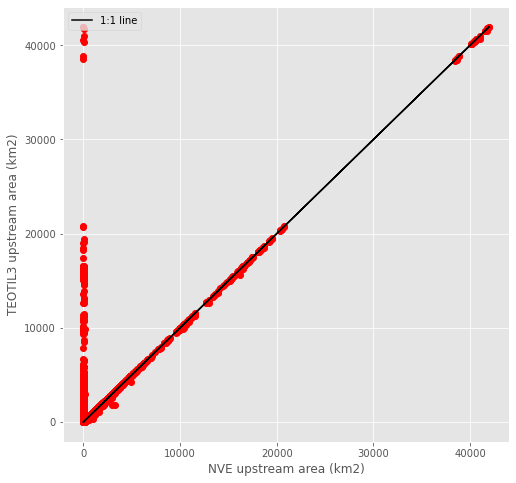

In [7]:
# Try to fix some inconsistencies in NVE's dataset
reg_gdf["upstr_a_km2"] = np.where(
    reg_gdf["upstr_a_km2"] == 0, reg_gdf["a_cat_land_km2"], reg_gdf["upstr_a_km2"]
)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(reg_gdf["upstr_a_km2"], reg_gdf["accum_upstr_area_km2"], "ro")
ax.plot(reg_gdf["upstr_a_km2"], reg_gdf["upstr_a_km2"], "k-", label="1:1 line")
ax.set_xlabel("NVE upstream area (km2)")
ax.set_ylabel("TEOTIL3 upstream area (km2)")
ax.legend(loc="upper left")

In [8]:
n_10pct = len(reg_gdf[(reg_gdf["accum_upstr_area_km2"] / reg_gdf["upstr_a_km2"]) > 1.1])
n_300pct = len(reg_gdf[(reg_gdf["accum_upstr_area_km2"] / reg_gdf["upstr_a_km2"]) > 10])

print(
    f"There are {n_10pct} catchments where the TEOTIL upstream areas are >10% larger than the NVE areas."
)
print(
    f"There are {n_300pct} catchments where the TEOTIL upstream areas are >1000% larger than the NVE areas."
)

There are 1713 catchments where the TEOTIL upstream areas are >10% larger than the NVE areas.
There are 1615 catchments where the TEOTIL upstream areas are >1000% larger than the NVE areas.


If I assume my accumulated areas are accurate (which seems reasonable for ~22k catchments out of ~24k based on the results above), then my accumulated values for discharge should also be OK. In other words, `accum_q_m3/s` gives an estimate for the mean flow (1961-90) from the "outflow" of each regine catchment.

NVE's lakes database includes the upstream area for each lake. I can therefore use the regine data to estimate the area upstream of the inflow to each regine (as `accum_upstr_area_km2 - local_a_cat_land_km2`). Within each regine, lakes with an upstream area greater than this value are likely to be located along the main river stem (because otherwise the lake's upstream area would be smaller than the regine's upstream area, except in unusual circumstances). Lakes along the main stem are the ones most relevant to the retention calculations and their long-term mean flow can be assumed equal to the outflow from the regine.

In [9]:
# Combine lake and regine datasets
lake_cols = [
    "regine",
    "vatnLnr",
    "area_km2",
    "catch_area_km2",
    "vol_Mm3",
    "res_time_yr",
]
reg_cols = [
    "regine",
    "accum_upstr_area_km2",
    "local_a_cat_land_km2",
    "accum_q_m3/s",
    "local_q_cat_m3/s",
]
df = pd.merge(lake_df[lake_cols], reg_gdf[reg_cols], on="regine", how="left")

# Calculate area upstream of the inflow to each regine
df["a_upstr_reg_km2"] = df["accum_upstr_area_km2"] - df["local_a_cat_land_km2"]

# Identify "main stem" lakes
df["is_main_stem"] = np.where(df["catch_area_km2"] > df["a_upstr_reg_km2"], 1, 0)

# Residence times will only be valid for 'main stem' lakes, since estimated flows
# are for the main stem (not tributaries)
df = df.query("is_main_stem == 1")

# Estimate residence time
df["res_time_est_yr"] = (1e6 * df["vol_Mm3"]) / (
    df["accum_q_m3/s"] * 60 * 60 * 24 * 365.25
)

print(len(df), "lakes identified along the main stem.")

df.head()

33860 lakes identified along the main stem.


,regine,vatnLnr,area_km2,catch_area_km2,vol_Mm3,res_time_yr,accum_upstr_area_km2,local_a_cat_land_km2,accum_q_m3/s,local_q_cat_m3/s,a_upstr_reg_km2,is_main_stem,res_time_est_yr
0,155.D1B,505,3.4267,16.06,127.800144,NaN,16.06,16.06,1.332016,1.332016,0.0,1,3.040310
6,155.D4Z,42010,0.0572,1.81,0.055370,NaN,84.07,84.07,5.108934,5.108934,0.0,1,0.000343
9,155.31,45204,0.1385,3.26,1.194448,NaN,8.24,8.24,0.475201,0.475201,0.0,1,0.079650
11,155.4G,45394,0.3475,1.73,1.795845,NaN,137.46,137.46,7.051698,7.051698,0.0,1,0.008070
12,155.AD62,45290,0.0449,0.17,0.173865,NaN,12.21,12.21,1.101708,1.101708,0.0,1,0.005001


NVE's depth dataset contains some estimates for residence times - mostly for the largest lakes. The code below compares these estimates with those from TEOTIL.

**Note:** There is one extreme outlier in the TEOTIL estimates where the residence time is >1000 years. Manual checking shows this is due to a problem in the NVE lake depth dataset where a lake has been assigned to the wrong regine unit, giving a small flow for a large lake. This is filtered out on the plot below and replaced with the measured value in the final dataset. Otherwise estimates seem reasonable: Pearson's and Spearman's correlation coefficients are both around 0.9 (see below).

As with lake volumes, I will use NVE's measured residence times where they are available and the estimated times elsewhere.

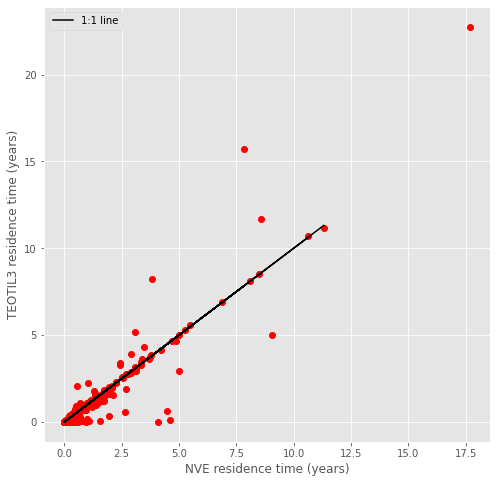

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
df2 = df.query("res_time_est_yr < 1000")
ax.plot(df2["res_time_yr"], df2["res_time_est_yr"], "ro")
ax.plot(df2["res_time_yr"], df2["res_time_yr"], "k-", label="1:1 line")
ax.set_xlabel("NVE residence time (years)")
ax.set_ylabel("TEOTIL3 residence time (years)")
ax.legend(loc="upper left")

In [11]:
print("Correlation coefficients")
methods = ["pearson", "spearman"]
for method in methods:
    corr = df2[["res_time_yr", "res_time_est_yr"]].corr(method=method).iloc[0, 1]
    print(f"{method}: {corr:.2f}")

Correlation coefficients
pearson: 0.93
spearman: 0.89


In [12]:
# Compare stats for lakes with measured data
df2.query("res_time_yr == res_time_yr").describe()

,vatnLnr,area_km2,catch_area_km2,vol_Mm3,res_time_yr,accum_upstr_area_km2,local_a_cat_land_km2,accum_q_m3/s,local_q_cat_m3/s,a_upstr_reg_km2,is_main_stem,res_time_est_yr
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.0,333.000000
mean,8010.465465,9.174824,597.088408,613.475808,1.066149,598.019760,29.017357,16.328193,1.070396,569.002402,1.0,1.040149
std,13013.583581,28.117901,2718.854125,3412.859952,1.886417,2715.644454,29.343374,48.542115,1.148628,2714.007702,0.0,2.190822
min,2.000000,0.031600,0.270000,0.167000,0.000950,1.370000,0.460000,0.073584,0.021874,0.000000,1.0,0.000831
25%,703.000000,0.804300,18.840000,7.140000,0.129502,29.130000,9.630000,1.089153,0.347757,0.000000,1.0,0.074613
50%,1772.000000,1.881300,62.410000,25.598000,0.413403,76.330000,18.360000,2.984975,0.718497,32.810000,1.0,0.365239
75%,5040.000000,5.726200,301.030000,111.448000,1.066000,279.550000,39.930000,13.693364,1.284738,268.300000,1.0,1.008862
max,48339.000000,369.317000,40109.980000,55360.520000,17.695219,40090.110000,256.950000,675.410402,7.785468,40050.570000,1.0,22.754530


In [13]:
# Use measured where available, otherwise use estimates
df["res_time_yr"] = df["res_time_yr"].combine_first(df["res_time_est_yr"])
df.dropna(subset="res_time_yr", inplace=True)
print(f"Residence times estimated for {len(df)} 'main stem' lakes.")
df.head()

Residence times estimated for 33860 'main stem' lakes.


,regine,vatnLnr,area_km2,catch_area_km2,vol_Mm3,res_time_yr,accum_upstr_area_km2,local_a_cat_land_km2,accum_q_m3/s,local_q_cat_m3/s,a_upstr_reg_km2,is_main_stem,res_time_est_yr
0,155.D1B,505,3.4267,16.06,127.800144,3.040310,16.06,16.06,1.332016,1.332016,0.0,1,3.040310
6,155.D4Z,42010,0.0572,1.81,0.055370,0.000343,84.07,84.07,5.108934,5.108934,0.0,1,0.000343
9,155.31,45204,0.1385,3.26,1.194448,0.079650,8.24,8.24,0.475201,0.475201,0.0,1,0.079650
11,155.4G,45394,0.3475,1.73,1.795845,0.008070,137.46,137.46,7.051698,7.051698,0.0,1,0.008070
12,155.AD62,45290,0.0449,0.17,0.173865,0.005001,12.21,12.21,1.101708,1.101708,0.0,1,0.005001
